<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
sns.set_style('whitegrid')
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [2]:
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows=1000

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

 #### My answer to question 1 is broken up into several parts:
1. Loading and Cleaning
 - 1.1 Load the data
 - 1.2 Remove the non-residential houses
 - 1.3 Set Id as index
 - 1.4 Rename the columns
 - 1.5 Identiy fixed features
 - 1.6 Handle null values
 - 1.7 Convert incorrect column types
 
 
2. Exploratory Data Analysis
 - 2.1 Explore area features
 - 2.2 Explore discrete features
 - 2.3 Explore year of construction/renovation
 - 2.4 Explore categorical features
 - 2.5 Explore sale price
 
 
3. Preprocessing
 - 3.1 Prepare the predictor matrix and the target
 - 3.2 Prepare training and testing splits
 
 
4. Modelling
 - 4.1 Determine the baseline
 - 4.2 Feature enginering
 - 4.3 Remove quasi-constant variables
 - 4.4 Address multicollinearity
 - 4.5 Lasso regression
 - 4.6 Plot the predicted prices against the actual prices
 - 4.7 Identify strong predictors


# 1. Loading and Cleaning

### 1.1 Load the data

In [3]:
house = pd.read_csv('./housing.csv')

In [4]:
house.shape

(1460, 81)

In [5]:
pd.set_option('display.max_columns', 150)
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 1.2 Remove the non-residential houses

In [6]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
#FV, RH, RL, RP and RM represent the residential houses
house = house[house['MSZoning'].isin(['FV','RH','RL','RP','RM'])]
house.reset_index()
house.shape

(1450, 81)

10 houses were removed from the dataframe!

### 1.3 Set Id as index

In [8]:
house.set_index('Id',inplace=True)

### 1.4 Rename columns

In [9]:
new_column_names = {
 'Id': 'id',
 'MSSubClass': 'build_class' ,
 'MSZoning': 'zone',
 'LotFrontage': 'frontage_lth',
 'LotArea': 'lot_A',
 'Street': 'st_type',
 'Alley': 'alley_type',
 'LotShape': 'lot_shape',
 'LandContour': 'flatness',
 'Utilities': 'utilities',
 'LotConfig': 'lot_config',
 'LandSlope': 'slope',
 'Neighborhood': 'neighborhood',
 'Condition1': 'cond_1',
 'Condition2': 'cond_2',
 'BldgType': 'build_type',
 'HouseStyle': 'house_style',
 'OverallQual': 'overall_Q',
 'OverallCond': 'overall_C',
 'YearBuilt': 'year_built',
 'YearRemodAdd': 'year_remodel',
 'RoofStyle': 'roof_style',
 'RoofMatl': 'roof_material',
 'Exterior1st': 'ext_cover_1',
 'Exterior2nd':'ext_cover_2',
 'MasVnrType': ' mas_vnr_type',
 'MasVnrArea': 'mas_vnr_A',
 'ExterQual': 'ext_Q',
 'ExterCond': 'ext_C',
 'Foundation': 'foundation',
 'BsmtQual': 'base_Q',
 'BsmtCond': 'base_C',
 'BsmtExposure': 'base_exp',
 'BsmtFinType1': 'base_fin_rate_1',
 'BsmtFinSF1': 'base_fin_A_1',
 'BsmtFinType2': 'base_fin_rate_2',
 'BsmtFinSF2':'base_fin_A_2',
 'BsmtUnfSF':'base_unfin_rate',
 'TotalBsmtSF': 'base_A',
 'Heating':'heat_type',
 'HeatingQC':'heating_QC',
 'CentralAir':'central_AC',
 'Electrical':'electrical',
 '1stFlrSF':'1st_floor_A',
 '2ndFlrSF':'2nd_floor_A',
 'LowQualFinSF': 'low_qual_fin_A',
 'GrLivArea': 'abv_grd_A',
 'BsmtFullBath': 'base_f_bath',
 'BsmtHalfBath': 'base_h_bath',
 'FullBath': 'no_f_bath',
 'HalfBath': 'no_h_bath',
 'BedroomAbvGr': 'no_bed_abv_grd',
 'KitchenAbvGr': 'no_kit_abv_grd',
 'KitchenQual':'kit_qual',
 'TotRmsAbvGrd':'no_rms_abv_grd',
 'Functional':'functionality',
 'Fireplaces':'no_fire',
 'FireplaceQu':'fire_qual',
 'GarageType':'garage_type',
 'GarageYrBlt':'garage_yr_blt',
 'GarageFinish': 'garage_fin',
 'GarageCars':'garage_cap',
 'GarageArea':'garage_A',
 'GarageQual':'garage_Q',
 'GarageCond':'garage_C',
 'PavedDrive':'paved_drive',
 'WoodDeckSF':'deck_A',
 'OpenPorchSF':'open_p_A',
 'EnclosedPorch':'enclosed_p_A',
 '3SsnPorch':'3Ssn_p_A',
 'ScreenPorch':'screen_p_A',
 'PoolArea':'pool_A',
 'PoolQC':'pool_QC',
 'Fence':'fence',
 'MiscFeature':'misc_feat',
 'MiscVal':'misc_val',
 'MoSold':'month_sold',
 'YrSold':'year_sold',
 'SaleType':'sale_type',
 'SaleCondition':'sale_cond',
 'SalePrice':'sale_price'
}

house.rename(columns=new_column_names, inplace=True)

#### Note:

- 'A' means 'area'

- 'Q' means 'quality

- 'C' means 'condition'

- 'p' means 'porch'

- 'f' means 'full'

- 'h' means 'half

- 'lth' means 'length'


### 1.5 Identify fixed features

In [10]:
# The only way to do this is to hard-code ...
fixed_features_cols = ['build_class',
 'zone',
 'frontage_lth',
 'lot_A',
 'st_type',
 'alley_type',
 'lot_shape',
 'flatness',
 'utilities',
 'lot_config',
 'slope',
 'neighborhood',
 'cond_1',
 'cond_2',
 'build_type',
 'house_style',
 'year_built',
 'year_remodel',
 'foundation',
 'base_Q',
 'base_exp',
 'base_A',
 '1st_floor_A',
 '2nd_floor_A',
 'abv_grd_A',
 'base_f_bath',
 'base_h_bath',
 'no_f_bath',
 'no_h_bath',
 'no_bed_abv_grd',
 'no_kit_abv_grd',
 'no_rms_abv_grd',
 'no_fire',
 'garage_type',
 'garage_yr_blt',
 'garage_cap',
 'garage_A',
 'open_p_A',
 'enclosed_p_A',
 '3Ssn_p_A',
 'screen_p_A',
 'pool_A',
 'misc_feat',
 'misc_val']

#create a dataframe for the fixed features!
fixed = house[fixed_features_cols]

In [11]:
fixed.shape

(1450, 44)

There are 44 fixed features that may help us predict price!

###  1.6 Handle null values

In [12]:
fixed.isnull().sum()

build_class          0
zone                 0
frontage_lth       259
lot_A                0
st_type              0
alley_type        1361
lot_shape            0
flatness             0
utilities            0
lot_config           0
slope                0
neighborhood         0
cond_1               0
cond_2               0
build_type           0
house_style          0
year_built           0
year_remodel         0
foundation           0
base_Q              37
base_exp            38
base_A               0
1st_floor_A          0
2nd_floor_A          0
abv_grd_A            0
base_f_bath          0
base_h_bath          0
no_f_bath            0
no_h_bath            0
no_bed_abv_grd       0
no_kit_abv_grd       0
no_rms_abv_grd       0
no_fire              0
garage_type         79
garage_yr_blt       79
garage_cap           0
garage_A             0
open_p_A             0
enclosed_p_A         0
3Ssn_p_A             0
screen_p_A           0
pool_A               0
misc_feat         1398
misc_val   

In [13]:
# for numeric columns, let's impute the column median for the null values
for column in fixed.columns:
    if fixed[column].dtype == 'int' or fixed[column].dtype == 'float':
        fixed[column].fillna(fixed[column].median(), inplace=True)

In [14]:
# for string columns, let's replace null values with 'NA'
for column in fixed.columns:
    if fixed[column].dtype =='object':
        fixed[column].fillna('NA', inplace=True)

In [15]:
fixed.isnull().sum().sum()

0

Great! Now we have no null entries!

### 1.7 Convert incorrect column types

In [16]:
#'build_class' is a categorical variable, so should be a string!
fixed['build_class'] = fixed['build_class'].astype('object')

# 2. Exploratory Data Analysis

### 2.1 Explore area features

In [17]:
#create a list of area features
area_features = ['lot_A','base_A','1st_floor_A','2nd_floor_A','abv_grd_A','garage_A','open_p_A','enclosed_p_A', '3Ssn_p_A','screen_p_A', 'pool_A']

#create a dataframe for the area featurs
area = fixed[area_features]

area.describe().T

,count,mean,std,min,25%,50%,75%,max
lot_A,1450.0,10523.831724,10012.185355,1300.0,7544.50,9496.0,11613.5,215245.0
base_A,1450.0,1059.408966,439.207322,0.0,796.00,992.0,1301.5,6110.0
1st_floor_A,1450.0,1164.773103,386.646095,334.0,882.50,1088.0,1392.0,4692.0
2nd_floor_A,1450.0,347.394483,437.094261,0.0,0.00,0.0,728.0,2065.0
abv_grd_A,1450.0,1517.698621,525.154207,334.0,1131.25,1466.0,1779.0,5642.0
garage_A,1450.0,473.277931,212.687621,0.0,336.00,480.0,576.0,1418.0
open_p_A,1450.0,46.537931,65.222761,0.0,0.00,25.0,68.0,547.0
enclosed_p_A,1450.0,21.536552,60.838826,0.0,0.00,0.0,0.0,552.0
3Ssn_p_A,1450.0,3.433103,29.416948,0.0,0.00,0.0,0.0,508.0
screen_p_A,1450.0,15.096552,55.893399,0.0,0.00,0.0,0.0,480.0


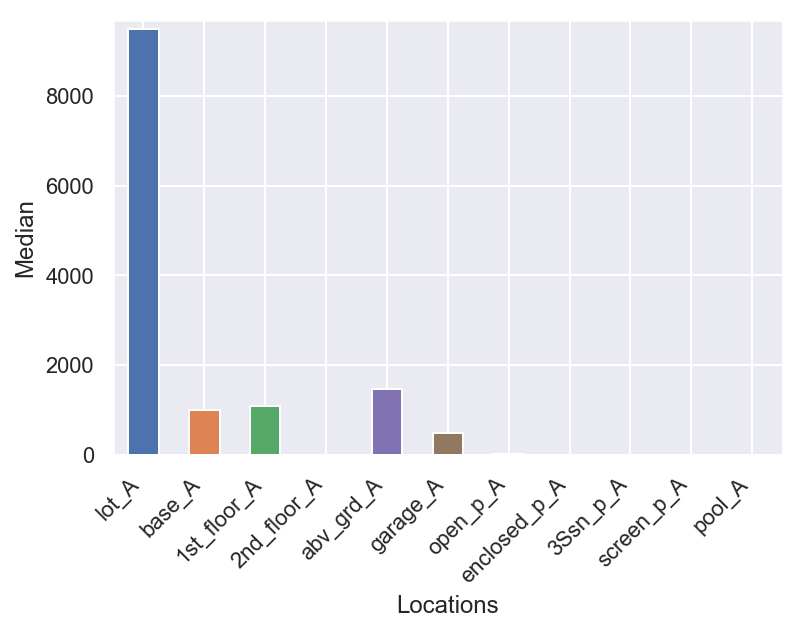

In [18]:
#Let's graph the median area for all of these locations. 
sns.set()
fig = area.median().plot(kind='bar')
plt.margins(0.02)
plt.ylabel('Median')
plt.xlabel('Locations')
fig.set_xticklabels(area.columns, rotation = 45, ha="right")
plt.show()

- The 'lot area' is by far the largest
- Basement area tends to be just shy of 1st floor area
- Most homes don't have a 2nd floor, porch or pool
- Most homes have a garage

In [19]:
# create a re-usable heatmap function!
def get_heatmap(df):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(9,7))
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)
    plt.show()

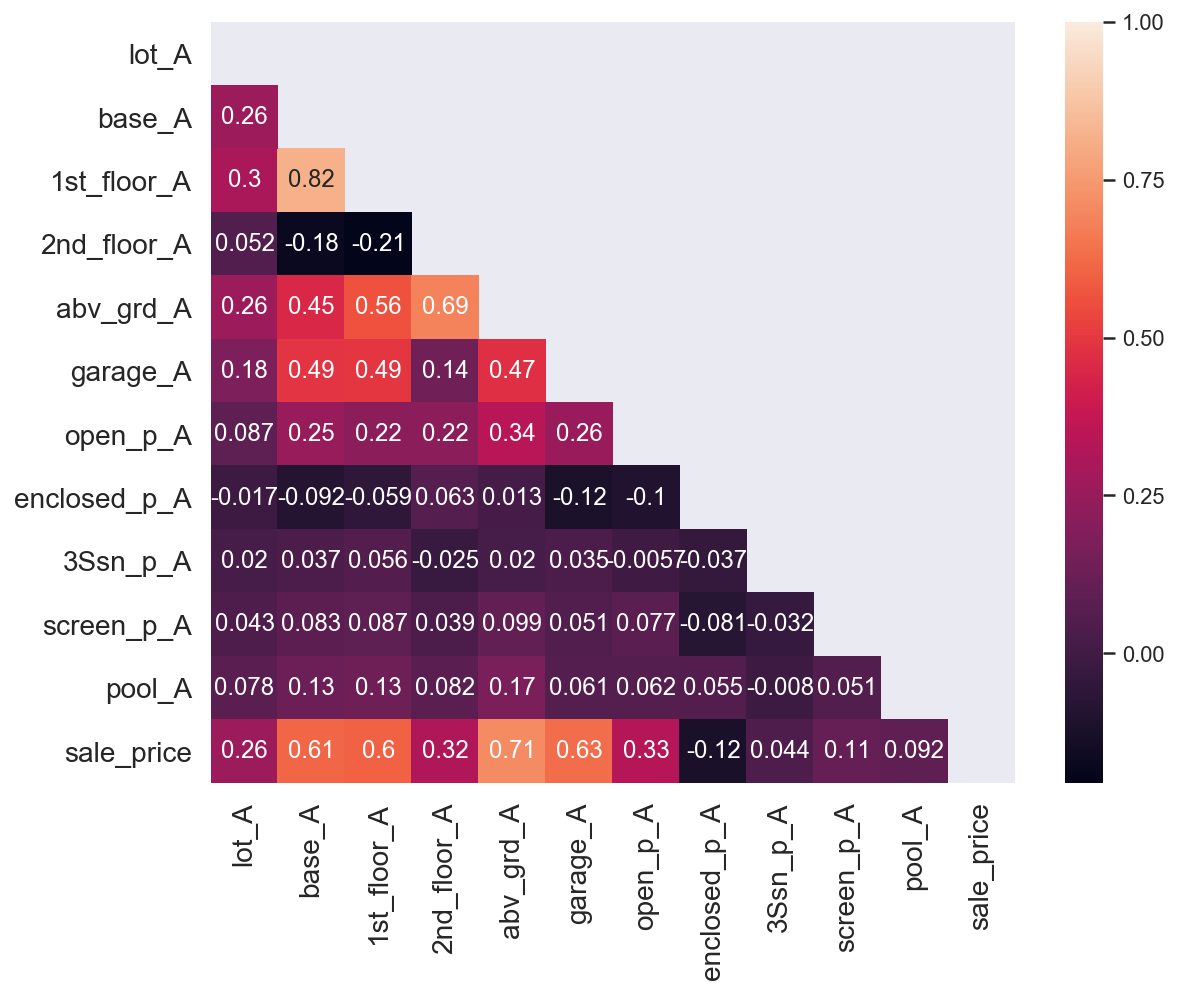

In [20]:
#Let's see the correlations these variables share with each other and the target
area['sale_price']= house['sale_price']
get_heatmap(area)

- '1st floor area' and 'basement area' are highly correlated (0.82)
- 'Basement area', '1st floor area', 'above ground area' and 'garage area' all share moderate correlations with 'sale price'. They could be helpful predictors.
- 'Porch areas' show very small correlations with the target

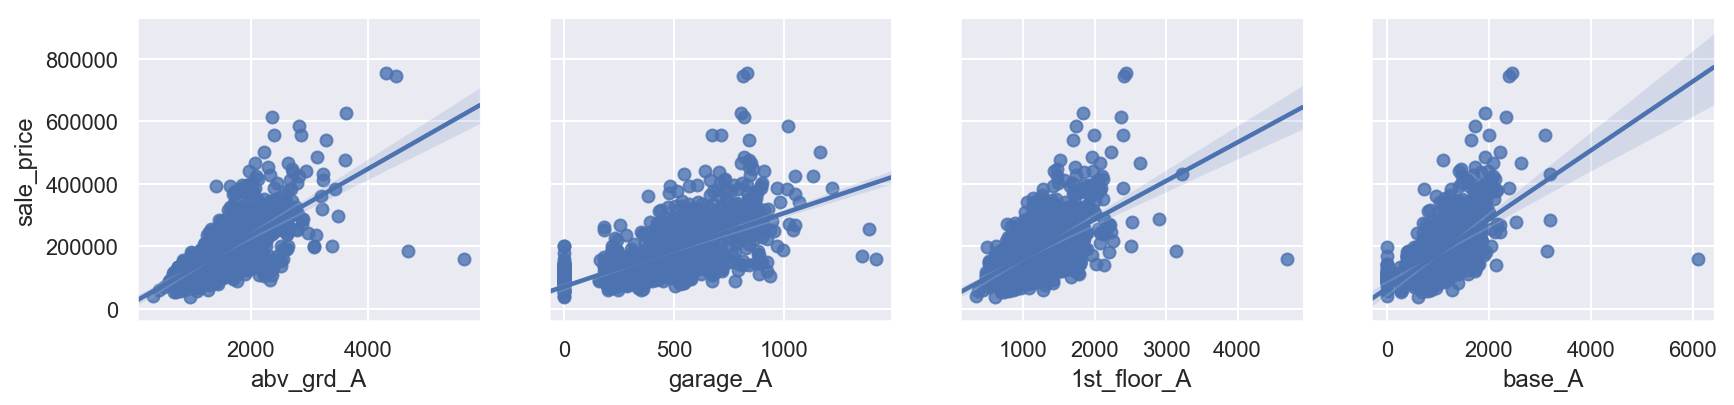

In [21]:
#let's construct pairplots for the interesting variables
sns.pairplot(area, 
             x_vars=['abv_grd_A', 'garage_A','1st_floor_A','base_A'],
             y_vars=['sale_price'],size=3,kind='reg');



'Basement area' shows the greatest slope here, suggesting that it could be a powerful predictor of 'sale price'!

### 2.2 Explore discrete features

In [22]:
#let's explore the features that are discrete!
discrete_features = ['base_f_bath','base_h_bath','no_f_bath','no_h_bath','no_bed_abv_grd','no_kit_abv_grd','no_rms_abv_grd','no_fire','garage_cap']
discrete = fixed[discrete_features]
discrete.describe().T

,count,mean,std,min,25%,50%,75%,max
base_f_bath,1450.0,0.427586,0.519394,0.0,0.0,0.0,1.0,3.0
base_h_bath,1450.0,0.057241,0.238249,0.0,0.0,0.0,0.0,2.0
no_f_bath,1450.0,1.568966,0.549549,0.0,1.0,2.0,2.0,3.0
no_h_bath,1450.0,0.384828,0.503450,0.0,0.0,0.0,1.0,2.0
no_bed_abv_grd,1450.0,2.870345,0.814645,0.0,2.0,3.0,3.0,8.0
no_kit_abv_grd,1450.0,1.046207,0.219643,0.0,1.0,1.0,1.0,3.0
no_rms_abv_grd,1450.0,6.522069,1.625324,2.0,5.0,6.0,7.0,14.0
no_fire,1450.0,0.616552,0.644991,0.0,0.0,1.0,1.0,3.0
garage_cap,1450.0,1.770345,0.745136,0.0,1.0,2.0,2.0,4.0


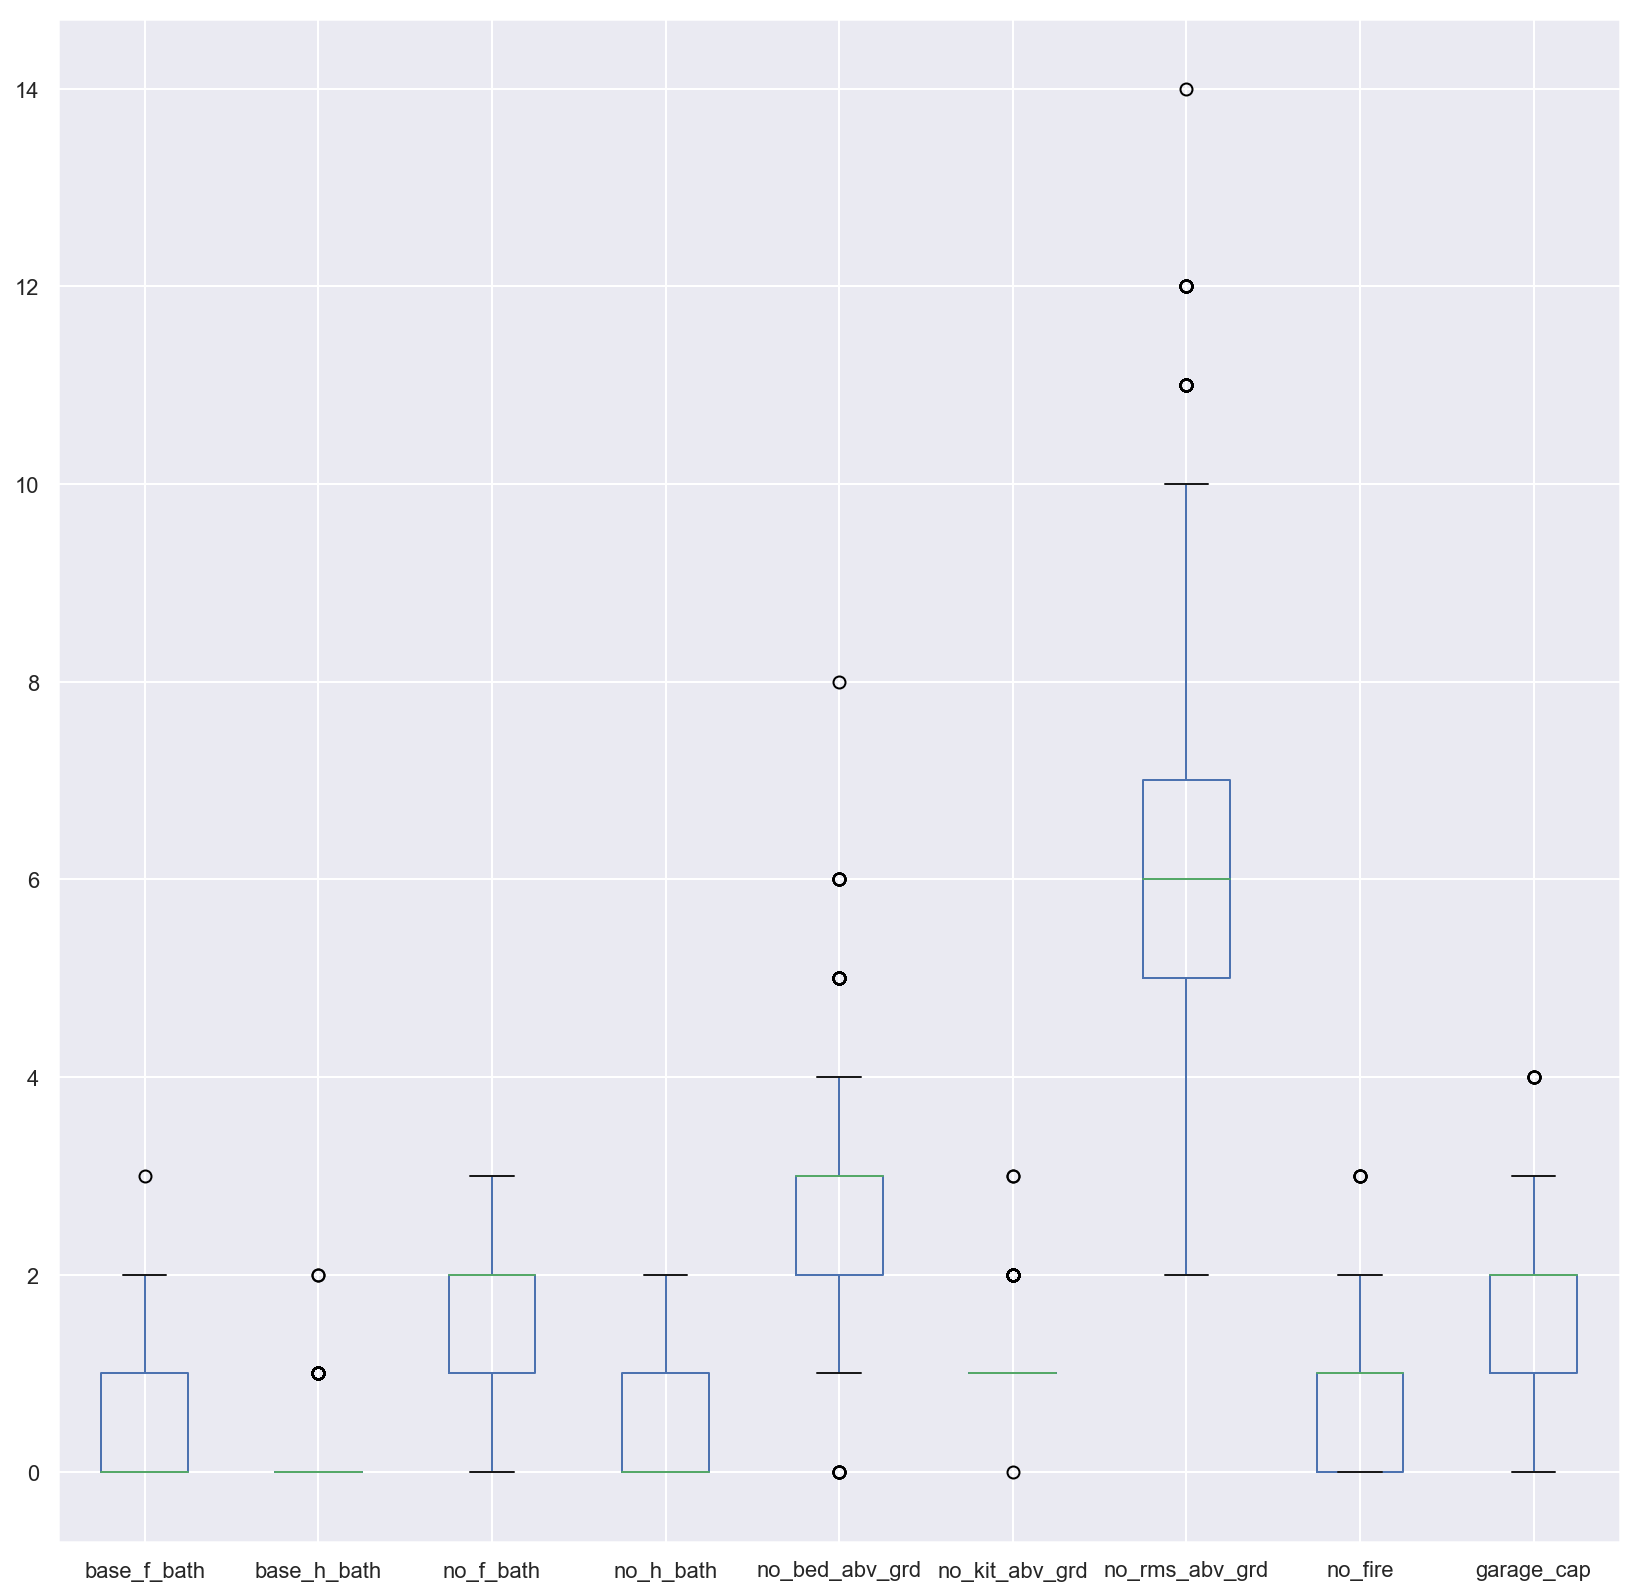

In [23]:
#let's visualise the discrete features using multiple boxplots
discrete.plot.box(figsize=(14,14));

We can see that a very "median" house has:

- 6 rooms above ground
- 3 bedrooms above ground
- 2 full bathrooms
- 1 kitchen above ground
- 2 car spots in the garage
- 0 basement bathrooms 
- 0 half bathrooms
- 0 fireplaces

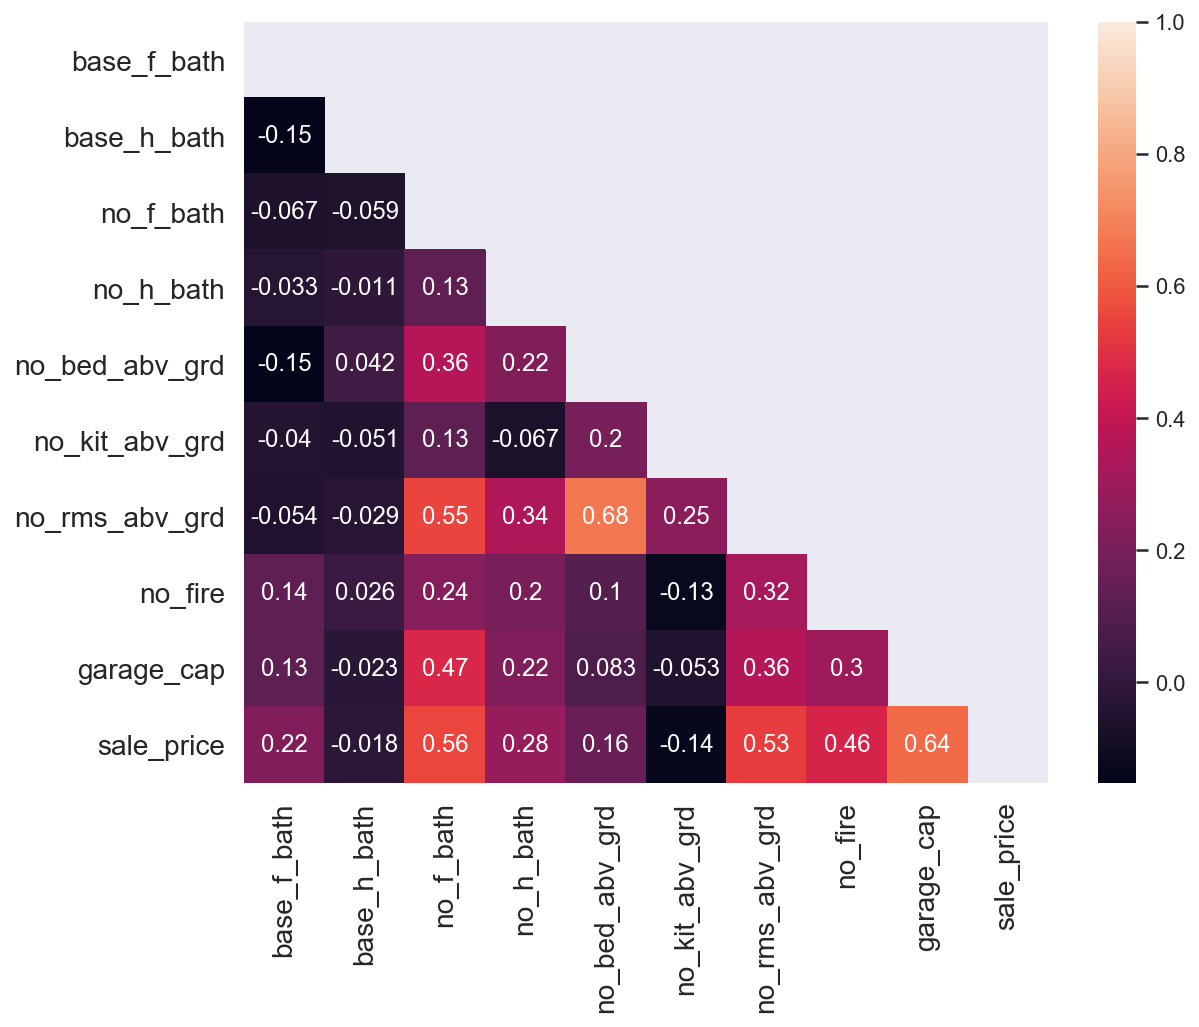

In [24]:
#Let's see the correlations these variables share with each other and the target
discrete['sale_price'] = house['sale_price']
get_heatmap(discrete)

- None of these features are highly correlated
- 'Garage capacity', 'number of full bathrooms', and 'number of rooms above ground' all share moderate correlations with 'sale_price'
- 'Number of basement half bathrooms' and 'number of kitchens above ground' show small correlations with the target

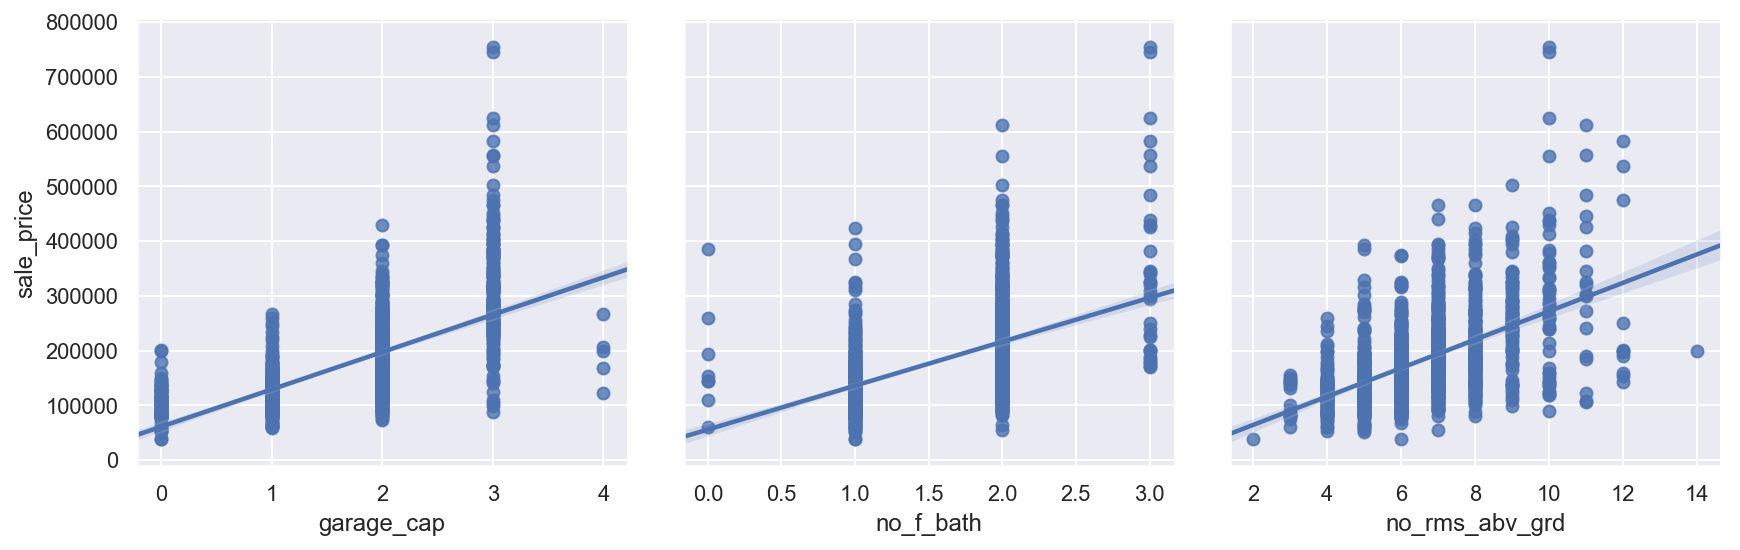

In [25]:
#let's construct the pairplots for these potential predictors
sns.pairplot(discrete, 
             x_vars=['garage_cap','no_f_bath','no_rms_abv_grd'],
             y_vars=['sale_price'],size=4,kind='reg');


'Number of rooms above ground' shows the greatest slope here, suggesting that it could be a powerful predictor of 'sale price'!

### 2.3 Explore year of construction/renovation

In [26]:
#now let's explore the remaining numerical columns
year_features = ['year_built','year_remodel']

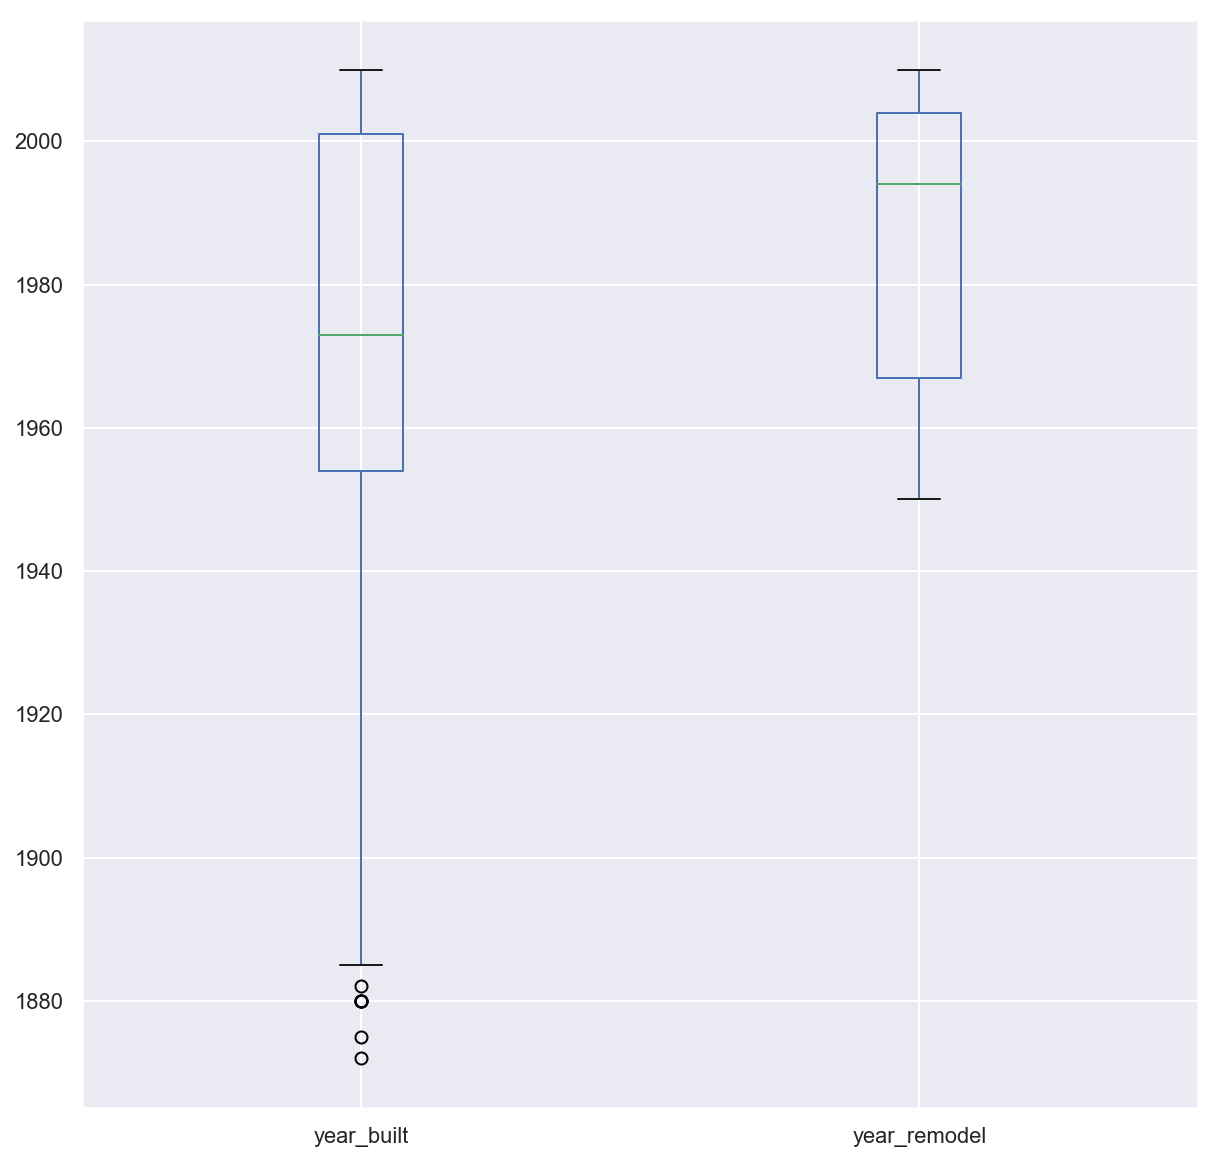

In [27]:
year = fixed[year_features]

year[['year_built','year_remodel']].plot.box(figsize=(10,10));

- Year of construction spans from 1872 to 2010, with a median of 1973. 
- All houses have been remodelled since 1950!

### 2.4 Explore categorical features

In [28]:
#create a list of categorical variables
categorical_columns = list(fixed.select_dtypes(['object']).columns)
#create a dataframe for these variables
categorical = fixed[categorical_columns]

categorical.describe().T

,count,unique,top,freq
build_class,1450,15,20,534
zone,1450,4,RL,1151
st_type,1450,2,Pave,1446
alley_type,1450,3,NA,1361
lot_shape,1450,4,Reg,916
flatness,1450,4,Lvl,1305
utilities,1450,2,AllPub,1449
lot_config,1450,5,Inside,1044
slope,1450,3,Gtl,1375
neighborhood,1450,25,NAmes,225


- 'Building Class' and 'Neighborhood' appear to exhibit the highest in-group variance
- Some of the categorical columns are still showing low variance: 'flatness', 'cond_1' and 'build_type'. Let's leave them for now. 

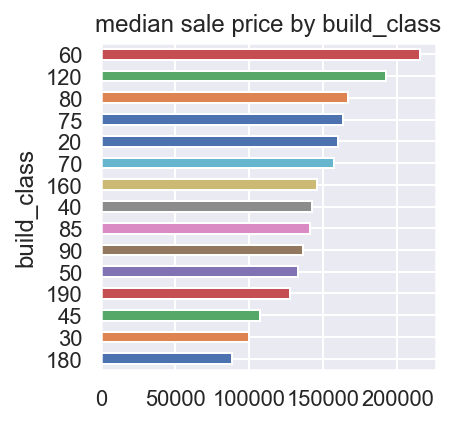

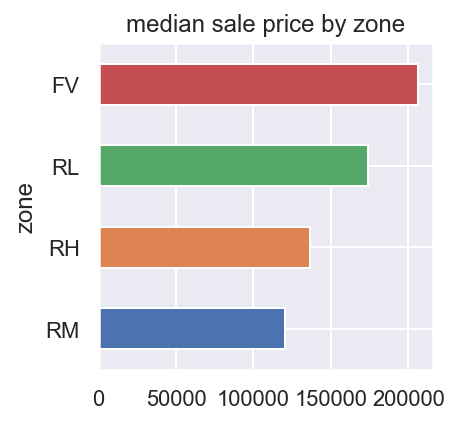

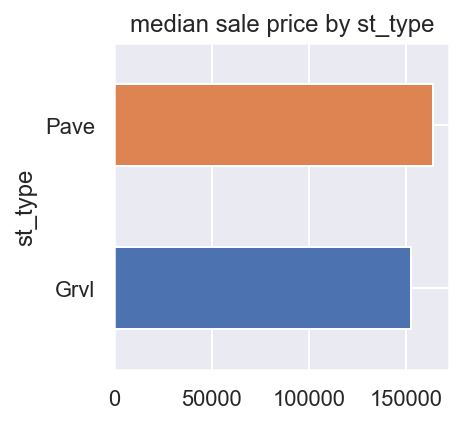

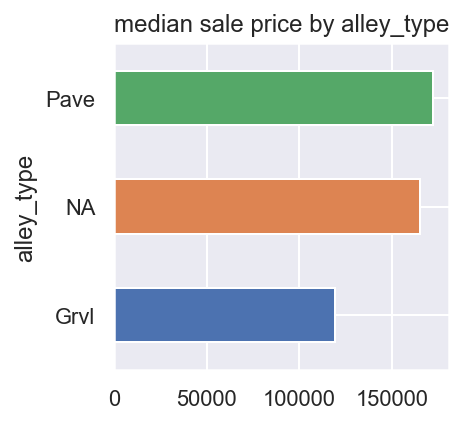

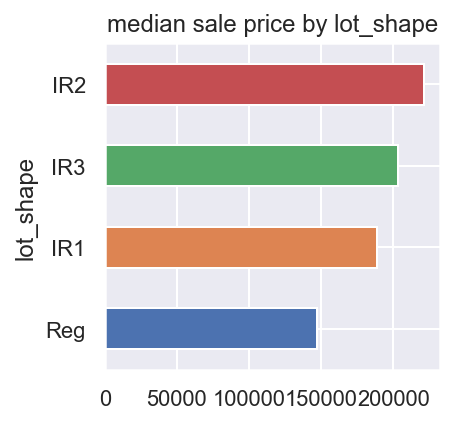

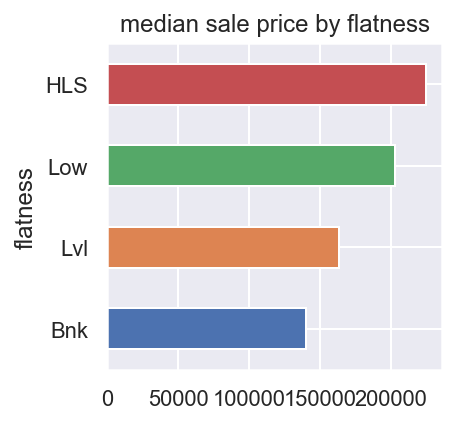

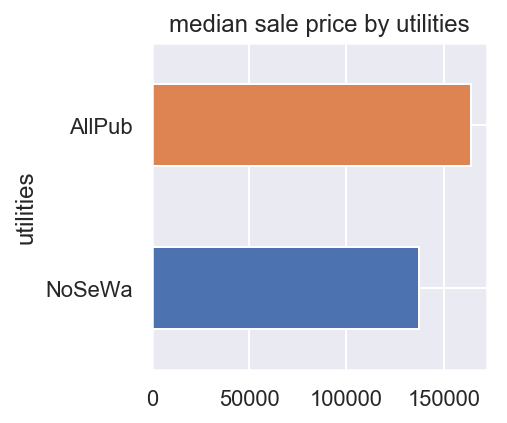

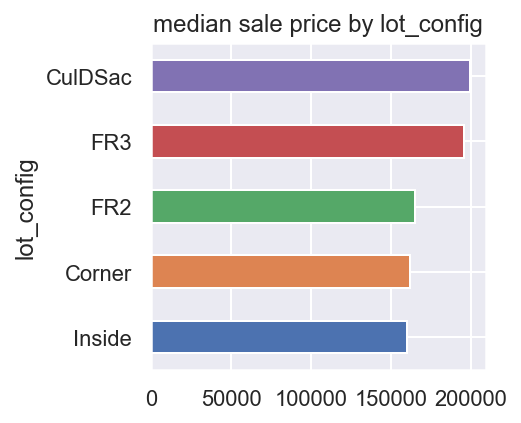

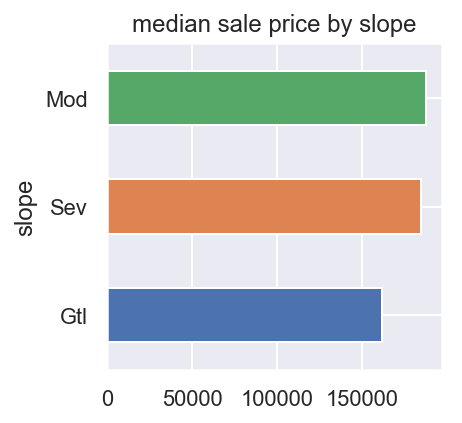

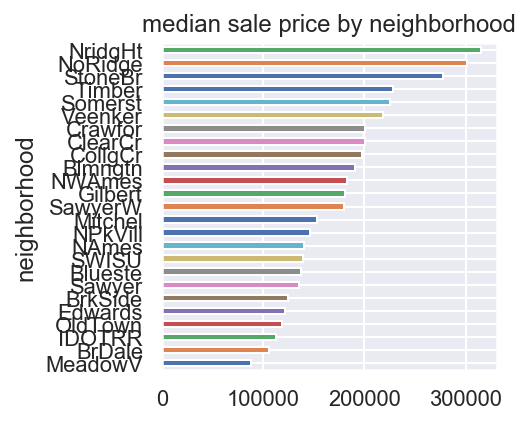

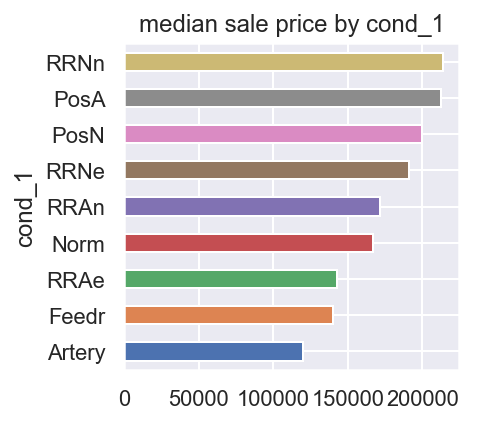

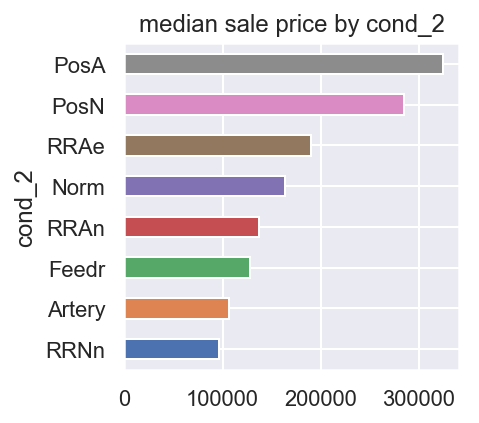

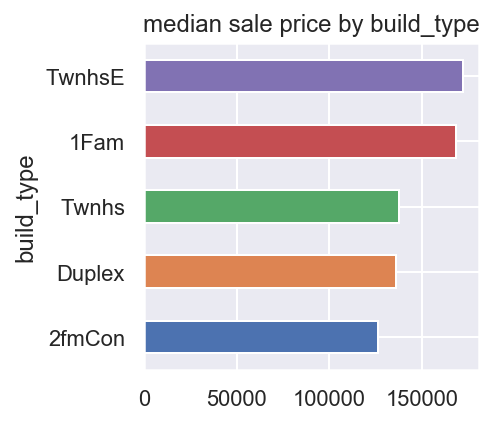

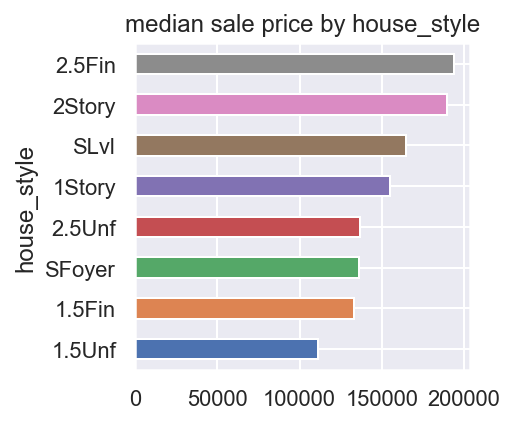

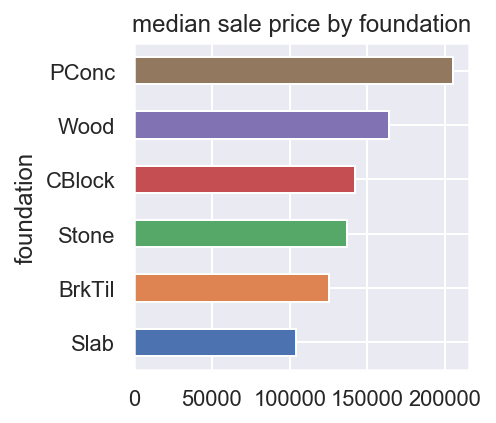

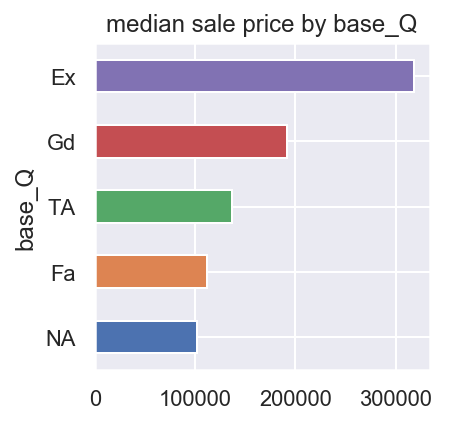

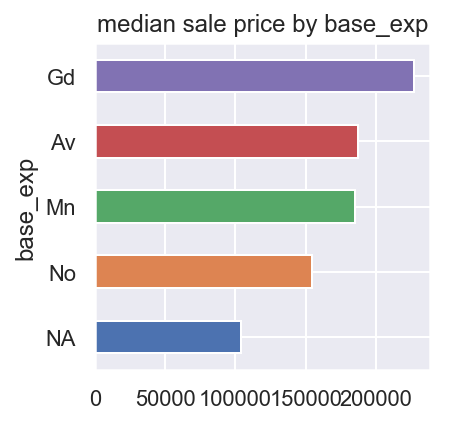

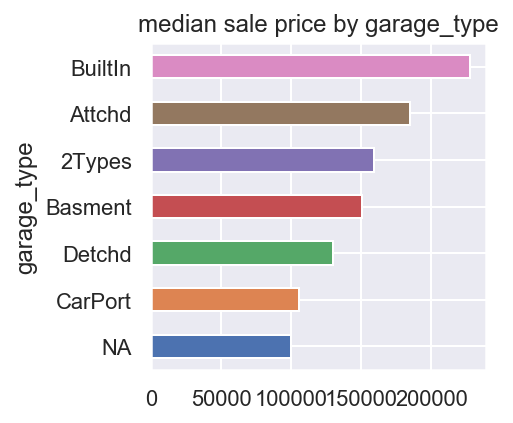

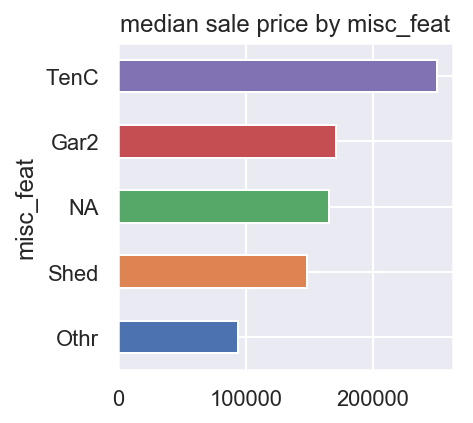

In [29]:
#let's see how 'sale_price' varies within categorical columns
categorical['sale_price'] = house['sale_price']

fun_columns = [column for column in categorical.columns if column != 'garage_yr_blt' and column != 'sale_price']
for column in fun_columns:
    categorical.groupby(column)['sale_price'].median().sort_values().plot(kind='barh',figsize=(3,3),title='median sale price by ' + column)
    plt.show()

As real estate is all about location, let's explore the neighborhoods further!

In [30]:
categorical.groupby('neighborhood')['sale_price'].median().sort_values(ascending=False)

neighborhood
NridgHt    315000
NoRidge    301500
StoneBr    278000
Timber     228475
Somerst    225500
Veenker    218000
Crawfor    200624
ClearCr    200250
CollgCr    197200
Blmngtn    191000
NWAmes     182900
Gilbert    181000
SawyerW    179900
Mitchel    153500
NPkVill    146000
NAmes      140000
SWISU      139500
Blueste    137500
Sawyer     135000
BrkSide    124300
Edwards    121750
OldTown    118250
IDOTRR     112500
BrDale     106000
MeadowV     88000
Name: sale_price, dtype: int64

In [31]:
#let's find a list of neighborhoods with median sale price above the global median
expensive_neighborhoods = []

for neighborhood in categorical['neighborhood'].unique():
    if (categorical[categorical['neighborhood'] == neighborhood]['sale_price'].median()) > house['sale_price'].median():
        expensive_neighborhoods.append(neighborhood)

In [32]:
#let's also create a list for the expensive classes
expensive_classes = ['60','120']

#These groups will help us engineer features later on!

In [33]:
# drop 'sale_price' from 'categorical', as we don't want it interfering later on!
categorical.drop(columns='sale_price', inplace=True)

### 2.5 Explore sale price

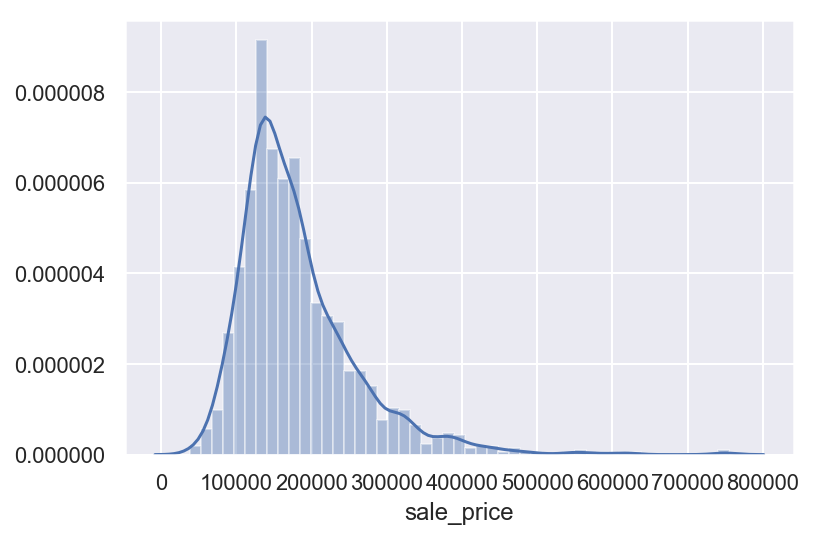

In [34]:
sns.distplot(house['sale_price']);

In [35]:
house['sale_price'].describe()

count      1450.000000
mean     181654.942069
std       79176.485241
min       37900.000000
25%      130000.000000
50%      163945.000000
75%      214000.000000
max      755000.000000
Name: sale_price, dtype: float64

# 3. Preprocessing

### 3.1 Prepare the predictor matrix and the target

In [36]:
ss = StandardScaler()

#select all numeric data
continuous = fixed._get_numeric_data()

# standardise all numeric data!
continuous_scaled = ss.fit_transform(continuous) 

#convert this array back into a dataframe
continuous_scaled_df = pd.DataFrame(continuous_scaled, index=continuous.index.tolist(), columns = continuous.columns)

In [37]:
# convert categorical variables into dummy-coded variables
categorical_dummies = pd.get_dummies(categorical, drop_first=True)

In [38]:
# concatenate the standardised numeric variables and the dummy-coded 
# variables into a single dataframe
X = pd.concat([continuous_scaled_df, categorical_dummies], axis=1)

#create the target
y = house['sale_price']

In [39]:
print(X.shape)
print(y.shape)

(1450, 131)
(1450,)


- Our predictor matrix has 131 columns!
- 25 columns are standardised continuous variables
- 106 columns are dummy-coded variables

### 3.2 Prepare training and testing splits

In [40]:
#find indices for pre-2010 data:
train_indices = house[house['year_sold'] != 2010].index.tolist()

#find indices for 2010 data:
test_indices = house[house['year_sold'] == 2010].index.tolist()

In [41]:
X_train = X.ix[train_indices]
X_test = X.ix[test_indices]
y_train = y.ix[train_indices]
y_test = y.ix[test_indices]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1278, 131)
(172, 131)
(1278,)
(172,)


#### We have 1278 rows for training and 172 rows for testing!

# 4. Modelling

### 4.1 Determine the baseline

As this is linear regression, the baseline will the mean of the target: $181654.94

####  Evaluate the basic model

Let's see how well a LR model on the unaltered predictor matrix performs.


In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.8681739412228765
0.8707780365090795


Wow! 

The LR on the unaltered matrix was able to massively outperform the baseline. Let's see if $R^2$ can be improved by engineering some new features onto the predictor matrix

### 4.2 Feature engineering

In [43]:
# Dummy-coded variables:

# Feature 1: presence of a porch
total_porch_A = house['open_p_A'] + house['enclosed_p_A'] + house['3Ssn_p_A'] + house['screen_p_A']
X['porch?'] = [1 if x > 0 else 0 for x in total_porch_A]

# Feature 2: presence of a 2nd floor
X['2nd_floor?'] = [1 if x > 0 else 0 for x in house['2nd_floor_A']]

# Feature 3: expensive neighborhood?
X['expen_neigh?'] = [1 if x in expensive_neighborhoods else 0 for x in house['neighborhood']]

# Feature 4: expensive building class?
X['expen_class?'] = [1 if x in [60, 120] else 0 for x in list(house['build_class'])]

In [44]:
# Continuous variables: 

# Feature 5: area of yard
X['yard_A'] = house['lot_A'] - house['1st_floor_A'] - house['garage_A']

# Feature 6: average area of room
X['av_room_A'] = house['abv_grd_A'] / house['no_rms_abv_grd']

# Feature 7: bathroom:bedroom ratio
X['bath__bed_ratio'] =  (house['no_f_bath'] + 0.5 * house['no_h_bath'])/ (house['no_bed_abv_grd'] + 1)

# Feature 8: years since house was built
X['years_since_blt'] = house['year_sold'] - house['year_built']

# Feature 9: years since house was remodelled
X['years_since_remod'] = house['year_sold'] - house['year_remodel']

#Feature 10: height of basement
def base_height(base_Q):
    if base_Q == 'EX':
        return 105
    if base_Q == 'Gd':
        return 95  
    if base_Q == 'TA':
        return 85 
    if base_Q == 'Fa':
        return 75 
    if base_Q == 'Po':
        return 65 
    else:
        return 0 

X['base_height'] = house['base_Q'].apply(base_height)

# standardise the continuous variables!
X[X.columns[-6:]] = ss.fit_transform(X[X.columns[-6:]])

Quick check! Let's see how well the engineered features correlate with each other and the target

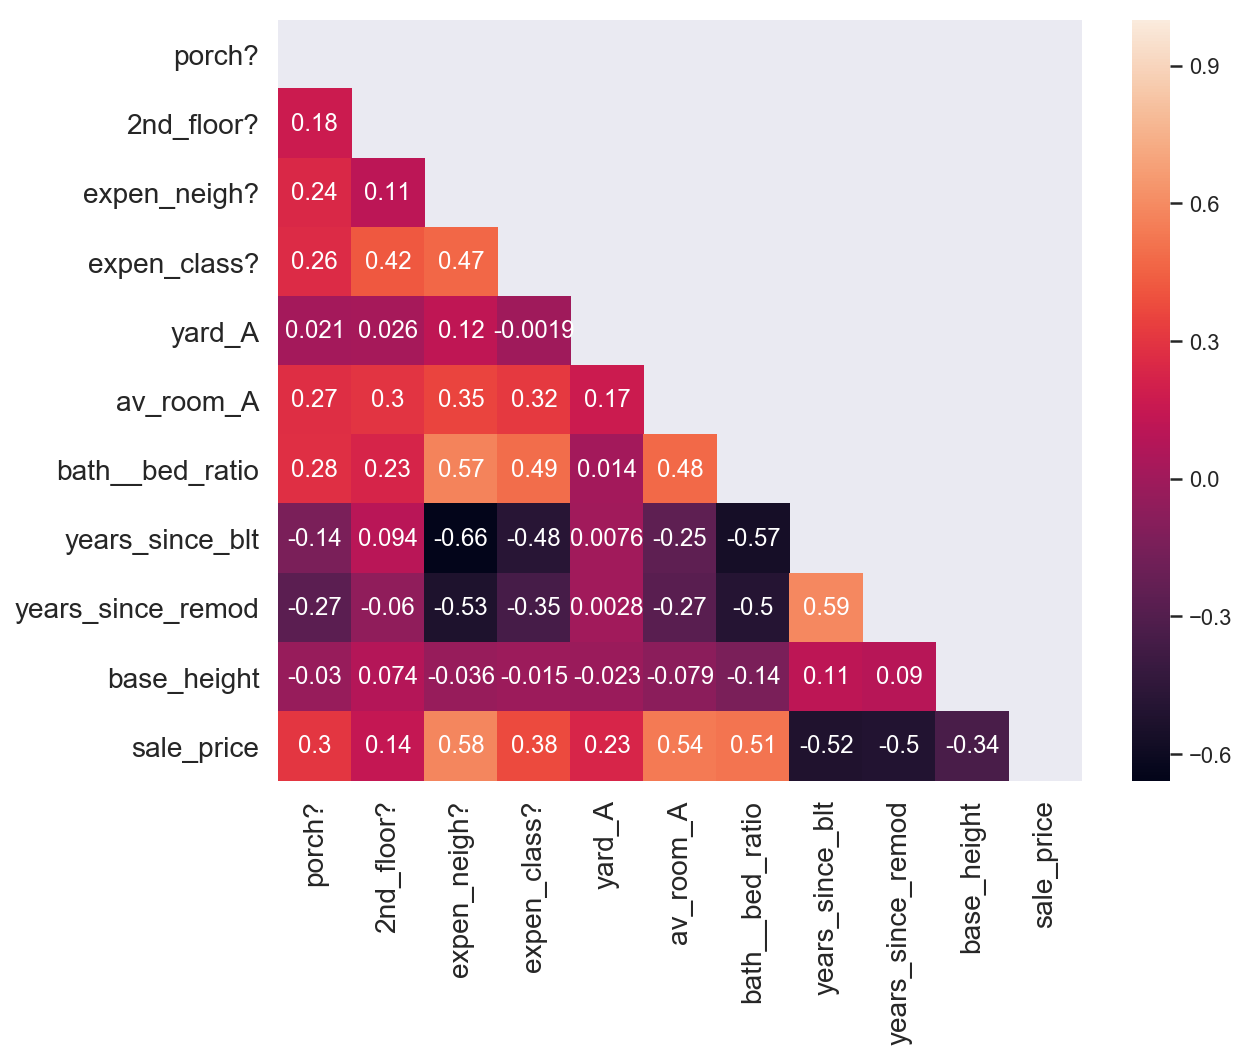

In [45]:
new_features = X[X.columns[-10:]]
new_features['sale_price'] = house['sale_price']
get_heatmap(new_features)

- None of the new features are highly correlated
- 'Expensive neighborhood' shares the strongest correlation with the target!

#### Evaluate the new model

In [46]:
X_train = X.ix[train_indices]
X_test = X.ix[test_indices]
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.8692009971351129
0.868570872461072


0.87 = 0.87 :/

This is slightly disappointing. I expected the addition of new features (many of which share moderate correlations with the target) to result in a higher $R^2$ value.


Let's keep going! Maybe the benefits of these features will show later!

### 4.3 Remove quasi-constant variables

Quasi-constant variables are variables with very low variance. We remove them because:
1. They are highly unlikely to be helpful predictors
2. We want to avoid multicollinearity issues later on

In [47]:
#drop the columns where one value occupies more than 99% of all values
low_var_columns = []
for column in list(X.columns):
    if np.max(X[column].value_counts(normalize=True)) > 0.99:
        low_var_columns.append(column)
        
X.drop(columns=low_var_columns, inplace=True)
low_var_columns

['pool_A',
 'build_class_40',
 'build_class_45',
 'build_class_180',
 'st_type_Pave',
 'lot_shape_IR3',
 'utilities_NoSeWa',
 'lot_config_FR3',
 'slope_Sev',
 'neighborhood_Blueste',
 'neighborhood_NPkVill',
 'neighborhood_Veenker',
 'cond_1_PosA',
 'cond_1_RRAe',
 'cond_1_RRNe',
 'cond_1_RRNn',
 'cond_2_Feedr',
 'cond_2_Norm',
 'cond_2_PosA',
 'cond_2_PosN',
 'cond_2_RRAe',
 'cond_2_RRAn',
 'cond_2_RRNn',
 'house_style_1.5Unf',
 'house_style_2.5Fin',
 'house_style_2.5Unf',
 'foundation_Stone',
 'foundation_Wood',
 'garage_type_CarPort',
 'misc_feat_Othr',
 'misc_feat_TenC']

#### Evaluate the new model

In [48]:
X_train = X.ix[train_indices]
X_test = X.ix[test_indices]
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.8605657939244965
0.8712744638626964


0.87 = 0.87. AGAIN!

Okay! Our $R^2$ here is the same as it was on the two previous models. This means we are explaining a similar amount of variance in the dependent variable.

However, this model is (probably) superior due to the dimensionality reduction. It has 21 fewer columns than the original matrix, and therefore is less likely to overfit.

### 4.4 Address multicollinearity

In [49]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

X.drop(columns=to_drop, inplace=True)

#### Evaluate the new model

In [50]:
X_train = X.ix[train_indices]
X_test = X.ix[test_indices]
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.8588193214836588
0.8737409205028424


0.87 for the fourth time!

Even though the $R^2$ hasn't changed, I believe this model is still an improvement as it has the smallest dimension (p = 94).


### 4.5 Lasso regression

Let's see if the model can be improved with lasso regression!

Quick note: lasso regression works by shrinking the coefficients in the model (to the extent where some variables are even zeroed out!). By doing this, we desensitive the effect of every independent variable on the dependent variable. This results in a small amount of bias, however, it ensures that the model is more generalisable to new data!

#### Evaluate the new model

In [51]:
#determine optimal alpha for lasso regression
lasso = LassoCV(n_alphas=500, cv=10, verbose=1)

#fit the training data using lasso 
model = lasso.fit(X_train, y_train)

# test the lasso model using the testing data
lasso.score(X_train, y_train)
lasso.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.875677188634965

0.87 for the fifth time! However, this is likely the best model as lasso regression minimises overfitting! Yay lasso!

### 4.6 Plot the predicted prices against the actual prices

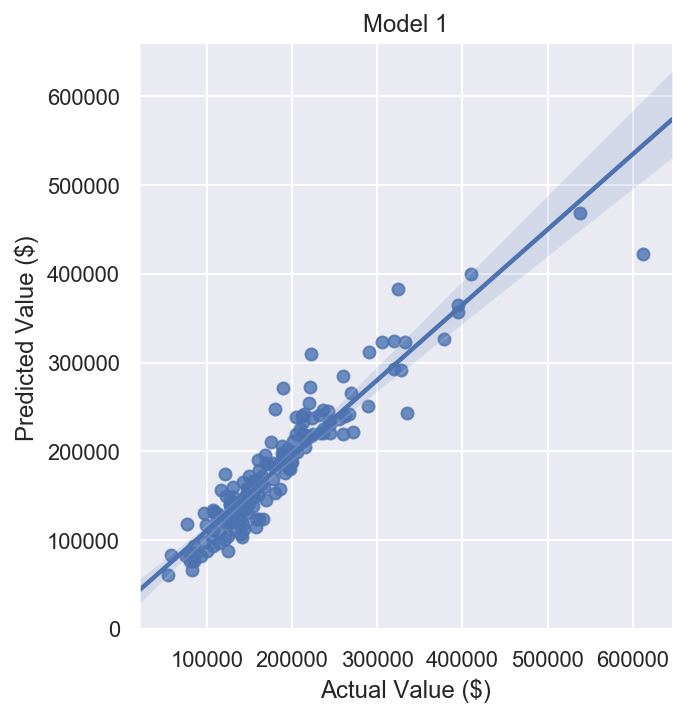

In [52]:
helper = pd.DataFrame()
helper['Actual Value ($)'] = y_test
helper['Predicted Value ($)'] = model.predict(X_test)
sns.lmplot(x='Actual Value ($)', y='Predicted Value ($)', data = helper);
ax = plt.gca()
ax.set_title("Model 1");

This is a fairly good plot. Most of the predictions are quite close to the actual data, with only a few outliers.

### 4.7 Identify strong predictors

In [53]:
# arrange the lasso coefficients into a pandas dataframe
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

# order the dataframe by the absolute value of the coefficient
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

# exclude coefficients that are equal to 0
strong_predictors = lasso_coefs[lasso_coefs['abs_coef'] != 0].reset_index(drop=True)

#adjust the index of this d
strong_predictors.index = np.arange(1, len(strong_predictors)+1)

strong_predictors

,variable,coef,abs_coef
1,neighborhood_NoRidge,60764.324793,60764.324793
2,neighborhood_StoneBr,54261.773507,54261.773507
3,neighborhood_NridgHt,44691.603101,44691.603101
4,base_Q_NA,-41745.951667,41745.951667
5,neighborhood_Somerst,21073.058887,21073.058887
6,build_class_160,-19182.284849,19182.284849
7,build_type_Twnhs,-18923.931110,18923.931110
8,base_exp_Gd,18119.914510,18119.914510
9,2nd_floor_A,15606.720587,15606.720587
10,flatness_HLS,15209.128710,15209.128710


- Many of the neighborhoods (such as NorthRidge, Stone Brook and North Ridge Heights) have a strong affect on the sale price. 
- The strongest continuous variables include: 'above ground area', 'basement height', 'garage capacity' and 2nd floor area'.
- The most powerful feature I engineered: 'expensive neighbourhood'
- Lasso effectively kept only 74 features! Dimensionality reduction again!

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

 #### My answer to question 2 is broken up into several parts:
 1. Construction of model 2
  - 1.1 Determine renovateable features
  - 1.2 Prepare the renovateable features matrix
  - 1.3 Concatenate fixed features and renovateable features
  - 1.4 Lasso regression
  
  
 2. Comparison of model 1 and model 2
  - 2.1 Predicted vs Actual plots
  - 2.2 Residual plots
  - 2.3 Variance
  - 2.4 Summary
  
 
 
 3. Important features
 
 
 4. Discussion

# 1. Construction of model 2

### 1.1 Determine renovateable features

In [54]:
#select house features that weren't included in the 'fixed' dataframe
renovateable_features = [x for x in house.columns if x not in fixed.columns]

#drop the features relating to the sale
renovateable_features = renovateable_features[:-5]

#create a dataframe for these features
renovateable = house[renovateable_features]

print(renovateable.shape)
renovateable.head()

(1450, 31)


,overall_Q,overall_C,roof_style,roof_material,ext_cover_1,ext_cover_2,mas_vnr_type,mas_vnr_A,ext_Q,ext_C,base_C,base_fin_rate_1,base_fin_A_1,base_fin_rate_2,base_fin_A_2,base_unfin_rate,heat_type,heating_QC,central_AC,electrical,low_qual_fin_A,kit_qual,functionality,fire_qual,garage_fin,garage_Q,garage_C,paved_drive,deck_A,pool_QC,fence
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,TA,GLQ,706,Unf,0,150,GasA,Ex,Y,SBrkr,0,Gd,Typ,NaN,RFn,TA,TA,Y,0,NaN,NaN
2,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,TA,ALQ,978,Unf,0,284,GasA,Ex,Y,SBrkr,0,TA,Typ,TA,RFn,TA,TA,Y,298,NaN,NaN
3,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,TA,GLQ,486,Unf,0,434,GasA,Ex,Y,SBrkr,0,Gd,Typ,TA,RFn,TA,TA,Y,0,NaN,NaN
4,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,Gd,ALQ,216,Unf,0,540,GasA,Gd,Y,SBrkr,0,Gd,Typ,Gd,Unf,TA,TA,Y,0,NaN,NaN
5,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,TA,GLQ,655,Unf,0,490,GasA,Ex,Y,SBrkr,0,Gd,Typ,TA,RFn,TA,TA,Y,192,NaN,NaN


### 1.2 Prepare the renovateable features matrix

In [55]:
#deal with null values

# for numeric columns, let's impute the column median for the null values
for column in renovateable.columns:
    if renovateable[column].dtype == 'int' or renovateable[column].dtype == 'float':
        renovateable[column].fillna(renovateable[column].median(), inplace=True)

# for string columns, let's replace null values with 'NA'
for column in renovateable.columns:
    if renovateable[column].dtype =='object':
        renovateable[column].fillna('NA', inplace=True)             

In [56]:
# standardise numeric data

# select all numeric data
continuous_2 = renovateable._get_numeric_data()

#standardise
continuous_scaled_2 = ss.fit_transform(continuous_2) 

# convert array back to dataframe
continuous_scaled_df_2 = pd.DataFrame(continuous_scaled_2, index=continuous_2.index.tolist(), columns = continuous_2.columns)


In [57]:
#create dummy-variables for categorical data

# create a dataframe for the categorical renovateable information
categorical_2 = renovateable.drop(columns = continuous_2.columns)

# convert to dummy-coded variables
categorical_dummies = pd.get_dummies(categorical_2, drop_first=True)

In [58]:
# concatenate standardised numeric and dummy-coded categorical variables
X_2 = pd.concat([continuous_scaled_df_2, categorical_dummies], axis=1)

In [59]:
#drop the columns where one value occupies more than 90% of all values
low_var_columns = []
for column in list(X_2.columns):
    if np.max(X_2[column].value_counts(normalize=True)) > 0.90:
        low_var_columns.append(column)
        
X_2.drop(columns=low_var_columns, inplace=True)

In [60]:
# address highly correlated pairs

# Create correlation matrix
corr_matrix = X_2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 80%
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

X_2.drop(columns=to_drop, inplace=True)

### 1.3 Concatenate fixed features and renovateable features

In [61]:
# concatenate the fixed dataframe (X) and the renovateable dataframe (X_2)
mega_X = pd.concat([X, X_2], axis=1)
mega_X.shape

(1450, 133)

### 1.4 Lasso Regression

In [62]:
X_train = mega_X.ix[train_indices]
X_test = mega_X.ix[test_indices]

#determine optimal alpha for lasso regression
lasso = LassoCV(n_alphas=500, cv=10, verbose=1)

#fit the training data using lasso 
model_2 = lasso.fit(X_train, y_train)

# test the lasso model using the testing data
lasso.score(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.8765609321874938

# 2. Comparison of model 1 (fixed features) and model 2 (fixed & renovateable features)

### 2.1 Predicted vs Actual plots

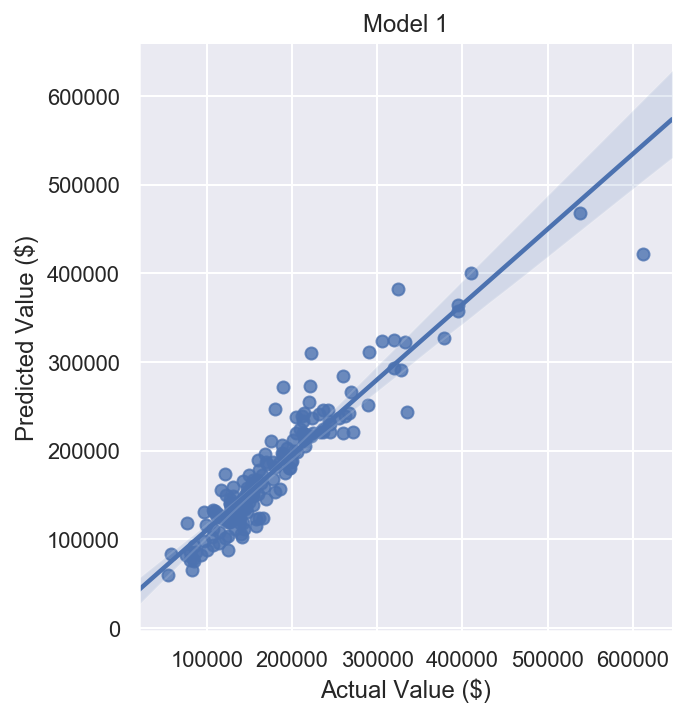

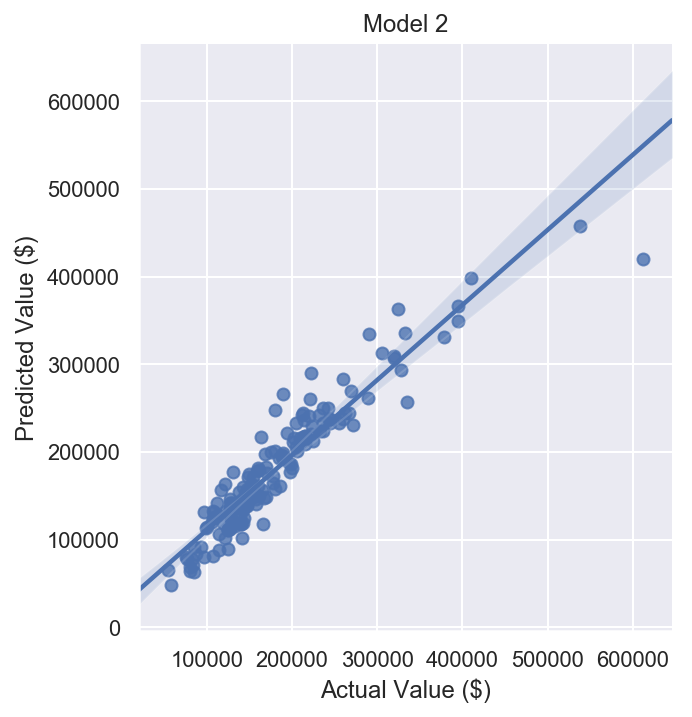

In [63]:
# create a dataframe with predicted and actual values
helper = pd.DataFrame()
helper['Actual Value ($)'] = y_test
helper['Predicted Value ($)'] = model.predict(X.ix[test_indices])

# create the lm plot for model 1
sns.lmplot(x='Actual Value ($)', y='Predicted Value ($)', data = helper);
ax = plt.gca()
ax.set_title("Model 1");

# reassign the predicted value for model 2
helper['Predicted Value ($)'] = model_2.predict(mega_X.ix[test_indices])

#create the lm plot for model 2
sns.lmplot(x='Actual Value ($)', y='Predicted Value ($)', data = helper);
ax = plt.gca()
ax.set_title("Model 2");

The two models have somewhat similar plots here. This is likely due to renoatebale features only adding a small amount of value to the model.

Notably, we can also see that predictions vary for different actual values. For less expensive houses, both models tend to overestimate, however, for more expensive houses, the models tends to underestimate. 

### 2.2 Residual Plots (using both training and testing data)

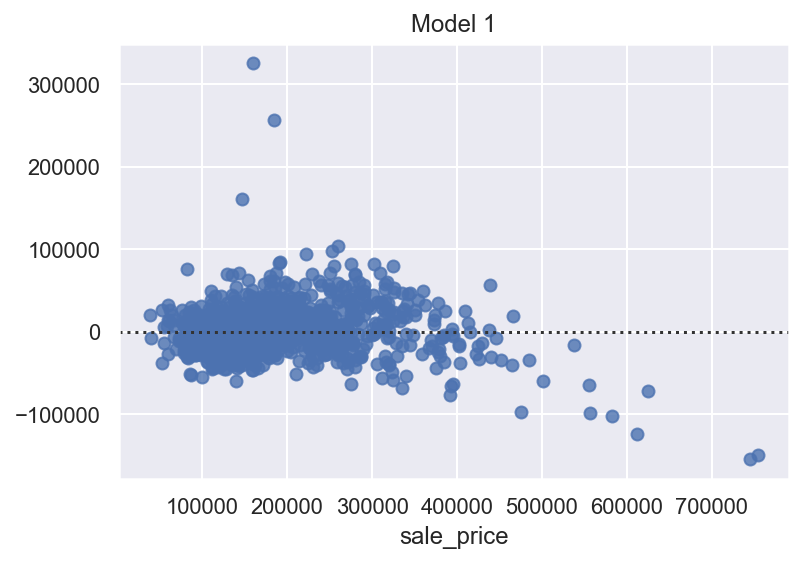

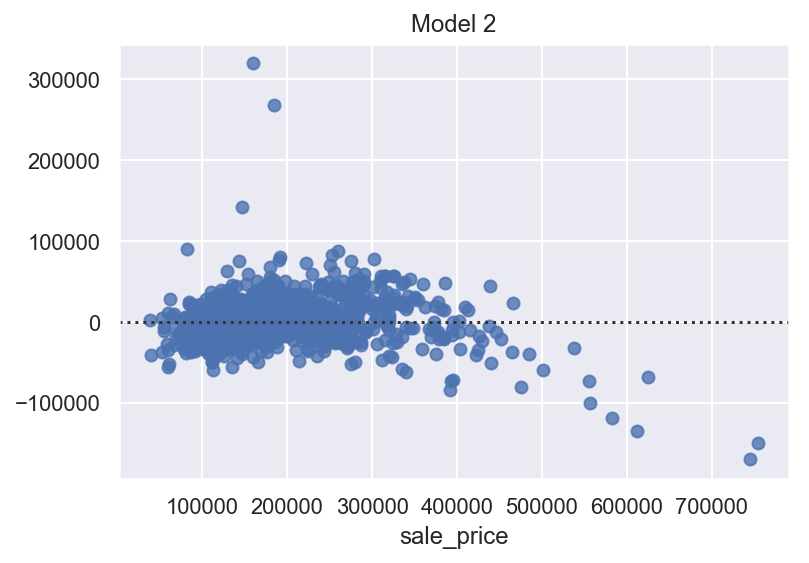

In [64]:
# create the residual plot for model 1
predictions = model.predict(X)
sns.residplot(y, predictions, color="b")
ax = plt.gca()
ax.set_title("Model 1");
plt.show()

# create the residual plot for model 2
predictions = model_2.predict(mega_X)
sns.residplot(y, predictions, color="b")
ax = plt.gca()
ax.set_title("Model 2");

Once again, we can see that both of the models perform similarly. Both of them tend to perform quite well on the testing data, and only a small amount of the residuals are significantly large. 

A potential issue could be underestimating the price of more expensive houses. It could be recommended to only use this model for houses that are less than $500 000. This would reduce the shock of any potential underestimates.

### 2.3 Variance

In [65]:
#calculate variance metrics for model 1
unexplained_variance = 1 - explained_variance_score(y, model.predict(X))
MAE = mean_absolute_error(y, model.predict(X))
print('Model 1')
print("Unexplained variance:", unexplained_variance)
print('Mean absolute error: '+ '$' + str(round(MAE, 2)))
print ('------------------------')

#calculate variance metrics for model 2
unexplained_variance = 1 - explained_variance_score(y, model_2.predict(mega_X))
MAE = mean_absolute_error(y, model_2.predict(mega_X))
print('Model 2')
print("Unexplained variance:", unexplained_variance)
print('Mean absolute error: '+ '$' + str(round(MAE, 2)))

Model 1
Unexplained variance: 0.1417165394669322
Mean absolute error: $18877.61
------------------------
Model 2
Unexplained variance: 0.12211905519023536
Mean absolute error: $16872.76


### Here, the numbers start to speak volumes. We can finally see which of the two models performs better. 


### Model 2 performs marginally better than model 1. In particular, it explains ~2% of the variance that model 1 cannot explain. This corresponds to a \\$2005 reduction in the mean absolute error. This means that, on average, model 2's predictions are $2005 closer to the actual price than model 1's predictions. Resultantly, model 2 would be the recommended model.

### 2.4 Summary

|  Comparison | Model 1 | Model 2 |
| --- | --- | --- |
| House attributes | Fixed | Fixed and renovateable |
| Number of features | 74 | 93 |
| Target | Sale price | Sale price |
| Validation method | Holdout | Holdout |
| Feature engineering? | Yes | No |
| Feature selection | Yes | Yes |
| Regularisation | LASSO | LASSO |
| Explained variance | 0.8583 | 0.8779 |
| Unexplained variance | 0.1417 | 0.1221 |
| Mean Absolute Error ($) | 18877.61 | 16872.76 |

# 3. Important features

In [66]:
# arrange the lasso coefficients into a pandas dataframe
lasso_coefs = pd.DataFrame({'variable':mega_X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

# order the dataframe by the absolute value of the coefficient
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

# exclude coefficients that are equal to 0
strong_predictors_2 = lasso_coefs[lasso_coefs['abs_coef'] != 0].reset_index(drop=True)

#adjust the index of this d
strong_predictors_2.index = np.arange(1, len(strong_predictors_2)+1)

#add a column for the renovateable features
strong_predictors_2['renovateable'] = ['yes' if x in X_2.columns else 'no' for x in strong_predictors_2['variable']]

strong_predictors_2

,variable,coef,abs_coef,renovateable
1,neighborhood_NoRidge,52704.909984,52704.909984,no
2,neighborhood_StoneBr,43101.202369,43101.202369,no
3,neighborhood_NridgHt,35040.386683,35040.386683,no
4,base_Q_NA,-20725.554714,20725.554714,no
5,build_class_160,-17607.761001,17607.761001,no
6,overall_Q,15905.610128,15905.610128,yes
7,base_exp_Gd,15261.760827,15261.760827,no
8,neighborhood_Somerst,15124.060530,15124.060530,no
9,house_style_1Story,13358.224241,13358.224241,no
10,2nd_floor_A,12973.856208,12973.856208,no


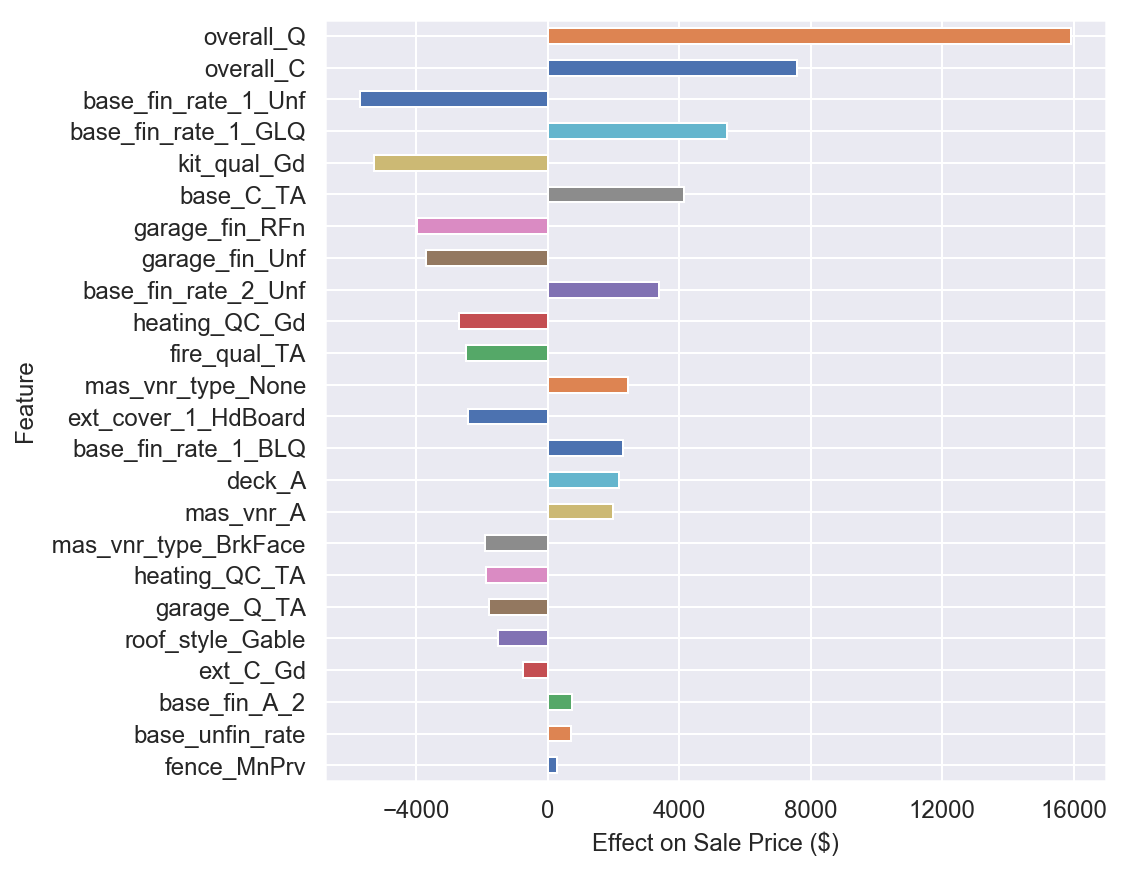

In [71]:
#let's imvestigate the important renovateble features
important_renov = strong_predictors_2[strong_predictors_2['renovateable'] == 'yes']

#create a helper dataframe
helper_2 = pd.DataFrame()
helper_2['variable'] = important_renov['variable'][::-1]
helper_2['coef'] = important_renov['coef'][::-1]

#create a horizontal bar plot from this dataframe
ax = helper_2.plot(x='variable',y='coef', kind='barh', figsize=(7, 7), legend=False, grid=True, xticks=[ -4000, 0, 4000, 8000, 12000, 16000], fontsize=12);
ax.set_xlabel("Effect on Sale Price ($)")
ax.set_ylabel("Feature");

Notably, renovateable features have a much weaker effect on the sale price than fixed features. Out of the top 10 important price predictors, only 1 of them is renovateable (overall quality). However, that doesn't mean that renovateable features are negligible. The effect of different renovations is discussed below.

#### Tazman's top 10 renovation recommendations (in order of importance):
1. Improve overall quality by one point (+\\$15 906)

2. Improve overall condition by one point (+\\$7 591)

3. Finish an unfinished basement (+\\$5 694)

4. Elevate basement finished area to 'good' (+\\$5 443)

5. Elevate kitchen quality to 'excellent' (+\\$5 278)

6. Elevate basement condition beyond 'average' (+\\$4 144)

7. Finish the interior of the garage (+\\$3 986)

8. Finish an unfinished garage (+\\$3 689)

9. Finish the second basement area (+\\$3 380)

10. Elevate the heating quality/condition to excellent (+\\$2 684)


#### Focus areas: basement, kitchen, garage.

#### In theory, this information could be useful to home improvement businesses. If the renovation benefits outweight the renovation costs, a particular home would be recommended for investment. 

# 4. Discussion

I have to say, I don't fully trust my model. Whilst creating my model and selecting features, I noticed the lasso coefficients would drastically differ. Sometimes 'kitchen excellence' would boost the price by \\$5000 dollars, while other times it would only boost the price by \\$9000. I think the value additions have to be taken in conjunction with an expert's opinion.


I think what the model does a good job of doing is showing the relative importance of different renovations. Quality metrics seem to be the most important renovations, and this is not a surprise. Additionally, the importance of basement, kitchen and garage improvements is also easy to understand.